## Objective
Run algorithm on spikeinterface recording

si_rec10.ipynb -> si_rec11.ipynb: Using spikeinterface groundtruth and making code more accessible

## Globals setup

In [20]:
%load_ext autoreload
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env OMP_NUM_THREADS=1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: OMP_NUM_THREADS=1


In [21]:
import sys
sys.path.append("/data/MEAprojects/PropSignal/src/run_alg/ext")  # Folder that contains .py files (you might not need to do this)

In [22]:
from copy import deepcopy
from importlib import reload
from multiprocessing import Pool
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm 

# Only for testing
from diptest import diptest
from sklearn.mixture import GaussianMixture

%autoreload 2
import si_rec11 as F  # This forces you to manually reload every time modification happens (prevents forgetfulness errors)

In [23]:
# Set paths

# region If you don't want to plot footprints
# from spikeinterface.extractors import NwbRecordingExtractor
# F.RECORDING = NwbRecordingExtractor("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/sub-MEAREC-250neuron-Neuropixels_ecephys.nwb")
# F.CHANS_RMS = None
# endregion

# If you want to plot footprints
import recording
RECORDING = F.RECORDING = recording.Recording("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/sub-MEAREC-250neuron-Neuropixels_ecephys.nwb", gain=False)
F.CHANS_RMS = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/chans_rms.npy", mmap_mode="r")
# endregion

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


In [24]:
# Set paths
ALL_CROSSINGS = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/all_crossings.npy", allow_pickle=True)
ELEC_CROSSINGS_IND = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/elec_crossings_ind.npy", allow_pickle=True)

In [25]:
# Set paths
F.TRACES = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/traces.npy", mmap_mode="r")  
F.OUTPUTS = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/outputs.npy", mmap_mode="r")

In [26]:
# Don't change these
F.ALL_CROSSINGS = [tuple(cross) for cross in ALL_CROSSINGS]
F.ELEC_CROSSINGS_IND = [tuple(ind) for ind in ELEC_CROSSINGS_IND]  # [(elec's cross times ind in all_crossings)]

TRAINING_MS = F.TRAINING_MS = (0, 5*60*1000)  # 0 min to 5 min in recording (in ms)
TESTING_MS = F.TESTING_MS = (5*60*1000, 10*60*1000)  # 5 min to 10 min in recording (in ms)

SAMP_FREQ = F.SAMP_FREQ = RECORDING.get_sampling_frequency()
NUM_ELECS = F.NUM_ELECS = RECORDING.get_num_channels()
ELEC_LOCS = F.ELEC_LOCS = RECORDING.get_channel_locations()

ALL_CLOSEST_ELECS = []
for elec in range(NUM_ELECS):
    elec_ind = []
    dists = []
    x1, y1 = ELEC_LOCS[elec]
    for elec2 in range(RECORDING.get_num_channels()):
        if elec == elec2:
            continue
        x2, y2 = ELEC_LOCS[elec2]
        dists.append(np.sqrt((x2 - x1)**2 + (y2 - y1)**2))
        elec_ind.append(elec2)
    order = np.argsort(dists)
    ALL_CLOSEST_ELECS.append(np.array(elec_ind)[order])   
F.ALL_CLOSEST_ELECS = ALL_CLOSEST_ELECS
    
F.FRONT_BUFFER = 60  # Model's front sample buffer

F.TRACES_FILT = F.TracesFiltWrapper(RECORDING)
F.STRINGENT_THRESH = 0.15  
F.N_BEFORE = F.N_AFTER = round(0.5 * SAMP_FREQ)  # Window for looking for electrode codetections

In [27]:
## RT-Sort main parameters ##

# Ignoring root elecs with too little activity #
F.MIN_ACTIVITY_ROOT_COCS = 2  # Root elec and MIN_ACTIVITY_ROOT_COCS inner elecs must detect spike with stringent threshold to count as detection
F.MIN_ACTIVITY = 30  # Root elec must have at least MIN_ACTIVITY detections to be considered

# General parameters #
# Stringent threshold is 0.15 (can't change this right now)
F.LOOSE_THRESH = 0.1  # Decimal form (not percent)
F.LOOSE_THRESH_LOGIT = F.sigmoid_inverse(F.LOOSE_THRESH)  # -2.1972245773362196  # For faster computation in spike splitting

F.INNER_RADIUS = 50
F.OUTER_RADIUS = 100

F.MIN_AMP_DIST_P = 0.1  # Minimum p-value for dip test to determine if distribution is unimodal (I think 0.05 might work better based on some test cases I saw)

# Preliminary propagation sequences #
F.SPLIT_ROOT_AMPS_AGAIN = True   # Whether to split preliminary propagation sequences based on root detections with GMM (some tests show that this could lead to oversplitting)
F.PRE_INTERELEC_ROOT_MAX_AMP_ONLY = True  # Whether to require spike to have maximum amplitude on root electrode. This increases merging in the second round, but this could be just because there is no spike splitting between sequences with different root electrodes.

# Electrode overlap #
F.MIN_LOOSE_DETECTIONS_N = 3 
F.MIN_LOOSE_DETECTIONS_R = 2/3  # R stands for ratio (not percent)
F.MIN_INNER_LOOSE_DETECTIONS = 2
F.MIN_ELEC_PROB = 0.03  # If an elec's mean prob is less than MIN_ELEC_PROB, it is set to 0

# Spike assignment # 
F.MAX_LATENCY_DIFF_SPIKES = 2.51  # In frames
F.MAX_AMP_MEDIAN_DIFF = 0.35  # Decimal form (not percent)
F.MAX_ROOT_AMP_MEDIAN_STD = 2  # Spike's amp on root electrode must be within MAX_ROOT_AMP_MEDIAN_STD standard deviations of mean

# Merging sequences #
F.MAX_LATENCY_DIFF_SEQUENCES = 2.51   # In frames
F.MAX_AMP_MEDIAN_DIFF_SEQUENCES = 0.35  # Decimal form (not percent)
    
# Spike assignment and merging sequences #
F.CLIP_LATENCY_DIFF = 5  # In frames
F.CLIP_AMP_MEDIAN_DIFF = 1  # Decimal form (not percent)

# Repeated detection removal # 
F.OVERLAP_TIME = 0.2  # For spike splitting and merging clusters with overlapping spikes
F.MIN_ELECS_FOR_ARRAY_NOISE = round(0.5 * NUM_ELECS)  # If this many elecs detect loose thresh on the same frame, spike is ignored


yay


## Test case
Look at progression of sequences on a single root electrode

In [28]:
# form_from_root
root_elec=0

time_frame=TRAINING_MS
verbose=True

coc_clusters = F.form_coc_clusters(root_elec, time_frame, 
                                   verbose=verbose)
# F.setup_coc_clusters(coc_clusters, verbose=verbose)

Starting with elec 0, loc: [  -24. -1910.]

Finding coocurrences


  0%|          | 0/4282 [00:00<?, ?it/s]

100%|██████████| 4282/4282 [00:02<00:00, 1452.66it/s]


2306 cocs total

Multimodal amp/median with p-value: 0.000
Dividing root cocs into amp/median groups with #cocs:
[1378, 928]
--------------------------------------------------
Starting on amp/median group with 1378 cocs

Comparing to elec 96, loc: [   -8. -1890.]
Found 4 clusters
550 cocs remaining

Comparing to elec 192, loc: [    8. -1910.]
Found 5 clusters
368 cocs remaining

Comparing to elec 1, loc: [  -24. -1870.]
Found 1 clusters
297 cocs remaining

Total: 10 clusters
--------------------------------------------------
Starting on amp/median group with 928 cocs

Comparing to elec 96, loc: [   -8. -1890.]
Found 4 clusters
542 cocs remaining

Comparing to elec 192, loc: [    8. -1910.]
Found 2 clusters
496 cocs remaining

Comparing to elec 1, loc: [  -24. -1870.]
Found 1 clusters
0 cocs remaining

Ending early because too few cocs remaining

Total: 17 clusters
Cluster 4: p-val=0.0257
Split cluster 4 into 4 clusters


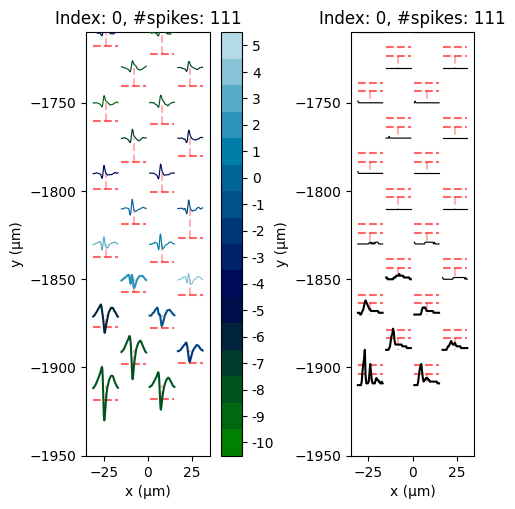

dip p-val: 0.992


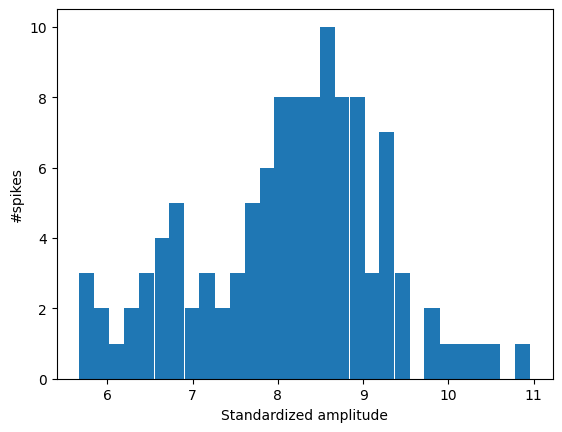

In [29]:
for i, cluster in enumerate(coc_clusters[:1]):     
    F.plot_elec_probs(cluster, idx=i)
    plt.show()
    
    amp_medians = F.get_amp_medians(cluster, n_cocs=None).flatten()
    print(f"dip p-val: {diptest(amp_medians)[1]:.3f}")
    
    plt.hist(amp_medians, bins=30)
    plt.xlabel("Standardized amplitude")
    plt.ylabel("#spikes")
    plt.show()


In [30]:
F.setup_coc_clusters(coc_clusters, verbose=verbose)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:27<00:00,  1.70s/it]


In [31]:
F.assign_spikes(coc_clusters, time_frame, verbose=verbose)
print(f"{len(coc_clusters)} clusters before 3 min spikes")
coc_clusters = [c for c in coc_clusters if len(c._spike_train) >= 3]  # What does this do? Should this be 30?
print(f"{len(coc_clusters)} clusters after 3 min spikes")

100%|██████████| 4027248/4027248 [00:08<00:00, 480418.48it/s]

16 clusters before 3 min spikes
16 clusters after 3 min spikes


In [32]:
merged_clusters = F.merge_coc_clusters(coc_clusters, verbose=verbose)  # This changes clusters in coc_clusters

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:21<00:00,  1.36s/it]



Merged 0 with 4
Latency diff: 0.75. Amp median diff: 0.03
Amp dist p-value 0.9935
#spikes:
Merge base: 312, Add: 128, Overlaps: 0
After merging: 438

Merged 1 with 4
Latency diff: 0.91. Amp median diff: 0.02
Amp dist p-value 0.9920
#spikes:
Merge base: 199, Add: 438, Overlaps: 0
After merging: 637

Merged 2 with 4
Latency diff: 0.90. Amp median diff: 0.03
Amp dist p-value 0.9149
#spikes:
Merge base: 118, Add: 637, Overlaps: 0
After merging: 745

Merged 12 with 15
Latency diff: 0.90. Amp median diff: 0.05
Amp dist p-value 0.7154
#spikes:
Merge base: 221, Add: 60, Overlaps: 0
After merging: 280

Merged [2, 4] with 5
Latency diff: 1.09. Amp median diff: 0.03
Amp dist p-value 0.8741
#spikes:
Merge base: 745, Add: 42, Overlaps: 0
After merging: 787

Merged [12, 15] with 13
Latency diff: 1.11. Amp median diff: 0.04
Amp dist p-value 0.6431
#spikes:
Merge base: 280, Add: 83, Overlaps: 0
After merging: 354

Merged [2, 4, 5] with 7
Latency diff: 1.20. Amp median diff: 0.03
Amp dist p-value 0.80

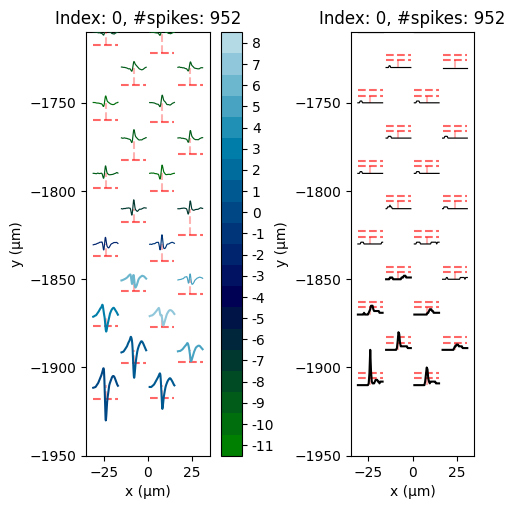

dip p-val: 0.903


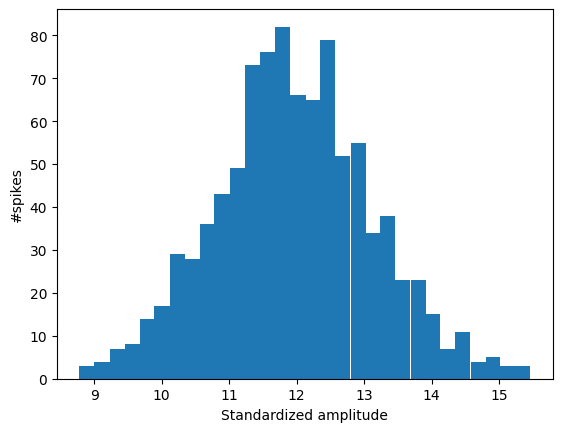

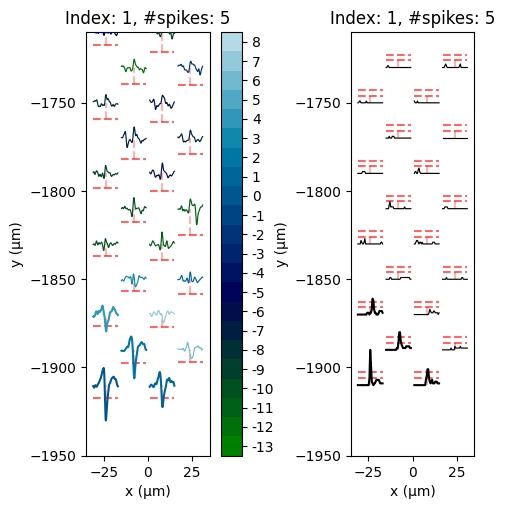

dip p-val: 0.032


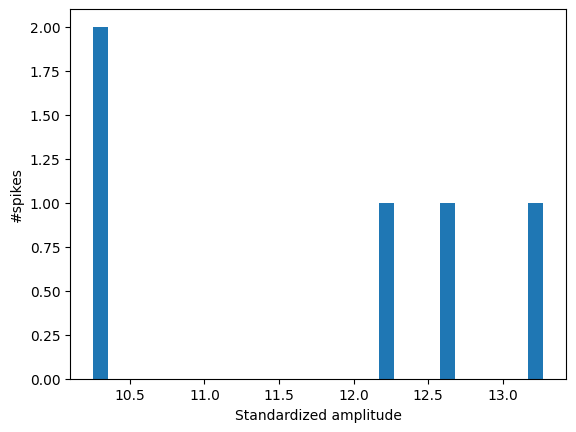

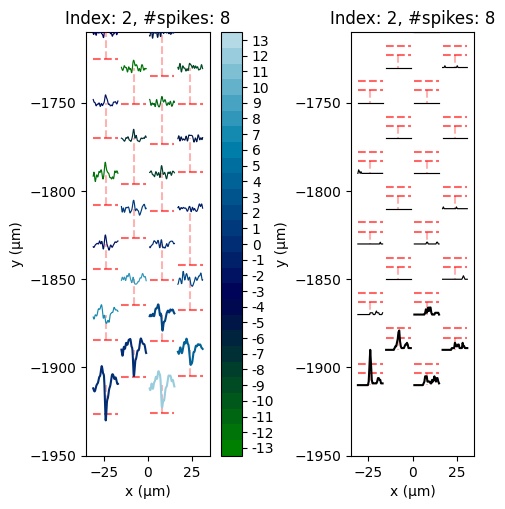

dip p-val: 0.951


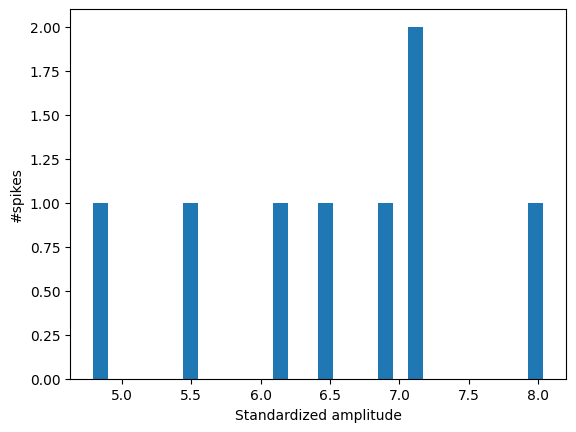

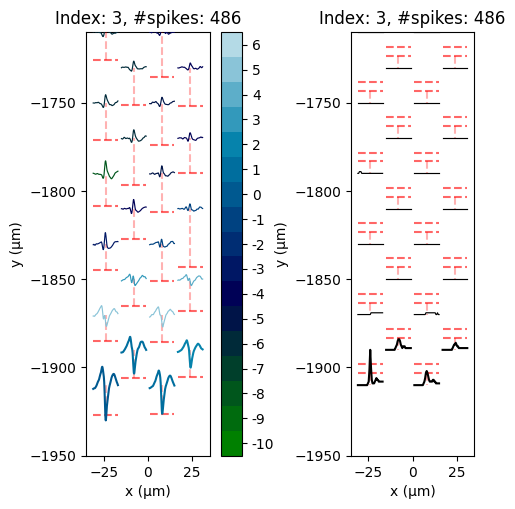

dip p-val: 0.897


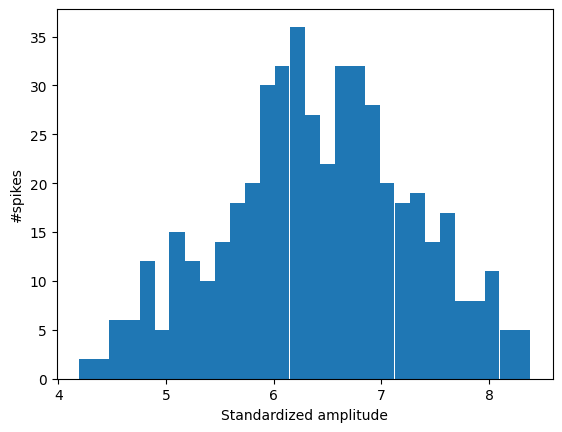

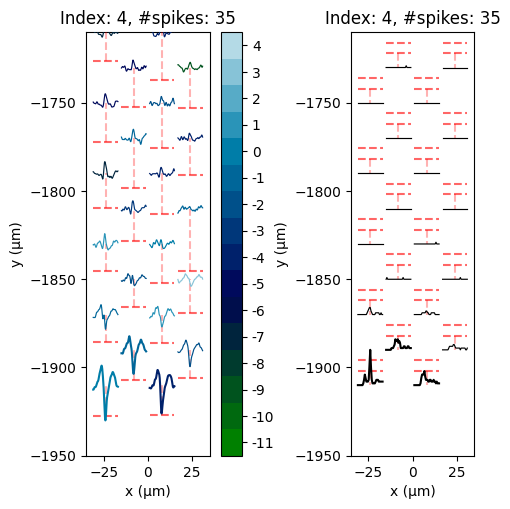

dip p-val: 0.554


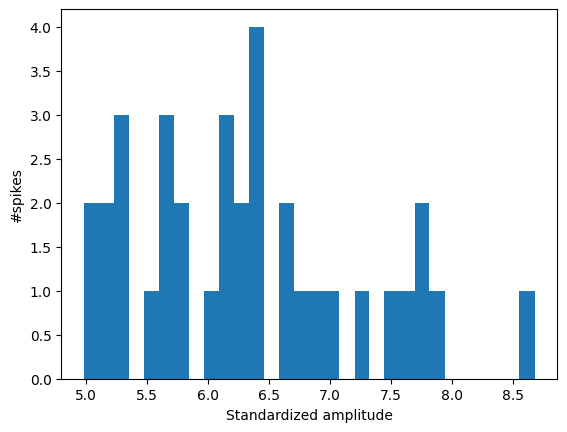

In [33]:
for i, cluster in enumerate(merged_clusters):     
    F.plot_elec_probs(cluster, idx=i)
    plt.show()
    
    amp_medians = F.get_amp_medians(cluster, n_cocs=None).flatten()
    print(f"dip p-val: {diptest(amp_medians)[1]:.3f}")
    
    plt.hist(amp_medians, bins=30)
    plt.xlabel("Standardized amplitude")
    plt.ylabel("#spikes")
    plt.show()


In [34]:
## Examine merge scores of seq pair
cluster_i = merged_clusters[2]
cluster_j = merged_clusters[3]

total_loose = len(set(cluster_i.loose_elecs).union(cluster_j.loose_elecs))
num_loose_overlaps = len(set(cluster_i.loose_elecs).intersection(cluster_j.loose_elecs))
print(f"Elec overlap: {num_loose_overlaps / total_loose:.2f}")

i_comp_elecs = cluster_i.comp_elecs
i_comp_elecs_set = set(i_comp_elecs)
j_comp_elecs = cluster_j.comp_elecs
comp_elecs = i_comp_elecs + [elec for elec in j_comp_elecs if elec not in i_comp_elecs_set]  # Prevents counting an elec more than once

# Get elec probs
i_elec_probs = cluster_i.all_elec_probs[comp_elecs]
j_elec_probs = cluster_j.all_elec_probs[comp_elecs]

# Compare latencies
i_latencies = cluster_i.all_latencies[comp_elecs][1:]
j_latencies = cluster_j.all_latencies[comp_elecs][1:] - cluster_i.all_latencies[comp_elecs[0]]
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=True)
latency_diff = np.abs(i_latencies - j_latencies)
latency_diff = np.clip(latency_diff, a_min=None, a_max=F.CLIP_LATENCY_DIFF)
latency_diff = np.sum(latency_diff * elec_weights)
print(f"Latency diff: {latency_diff:.2f}")

i_amp_medians = cluster_i.all_amp_medians[comp_elecs]
j_amp_medians = cluster_j.all_amp_medians[comp_elecs]                
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=False)
amp_median_div = (i_amp_medians + j_amp_medians) / 2
amp_median_diff = np.abs((i_amp_medians - j_amp_medians)) / amp_median_div
amp_median_diff = np.clip(amp_median_diff, a_min=None, a_max=F.CLIP_AMP_MEDIAN_DIFF)
amp_median_diff = np.sum(amp_median_diff * elec_weights)
print(f"Amp diff : {amp_median_diff:.2f}")

for root_elec in set(cluster_i.root_elecs + cluster_j.root_elecs):
    root_amps_i = cluster_i.every_amp_median[root_elec, :] # get_amp_medians(cluster_i, root_elec=root_elec)
    root_amps_j = cluster_j.every_amp_median[root_elec, :] # get_amp_medians(cluster_j, root_elec=root_elec)
    dip, pval = diptest(np.concatenate([root_amps_i, root_amps_j]))
    print(f"Elec {root_elec} p-val: {pval:.2f}")

Elec overlap: 0.80
Latency diff: 2.55
Amp diff : 0.11
Elec 0 p-val: 0.54


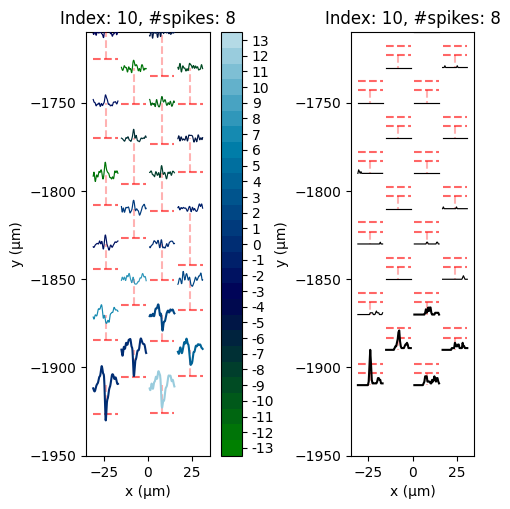

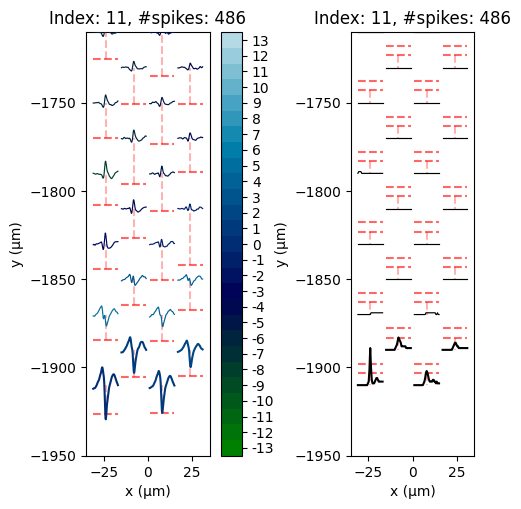

In [35]:
# Plot sequences using same scale
amp_kwargs, prob_kwargs = F.plot_elec_probs(cluster_i)
plt.show()
F.plot_elec_probs(cluster_j, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.show()

## Run full RT-Sort
Excluding running DL model

In [36]:
MIN_SPIKES = 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000

15.0


In [37]:
# From preliminary propagation sequences to first round of merging
def job(root_elec):
    merges = F.form_from_root(root_elec, TRAINING_MS)
    return merges
  
np.random.seed(1150)
all_sequences = []
with Pool(processes=20) as pool:
    for sequences in tqdm(pool.imap_unordered(job, range(NUM_ELECS)), total=NUM_ELECS):
        all_sequences += sequences
    
for idx, seq in enumerate(all_sequences):
    seq.idx = idx
print(f"{len(all_sequences)} sequences before interelec merging")

 14%|█▍        | 53/384 [03:29<18:26,  3.34s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 41%|████      | 158/384 [09:58<08:50,  2.35s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 82%|████████▏ | 314/384 [19:23<03:05,  2.65s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 83%|████████▎ | 318/384 [19:32<02:37,  2.39s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 88%|██

932 sequences before interelec merging


In [38]:
# Second round of merging
merged_sequences = F.merge_coc_clusters(all_sequences, auto_setup_coc_clusters=False, 
                                        verbose=True)



Merged 266 with 478
Latency diff: 0.14. Amp median diff: 0.02
Amp dist p-value 0.9534
#spikes:
Merge base: 382, Add: 686, Overlaps: 2
After merging: 1066

Merged 682 with 716
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9949
#spikes:
Merge base: 916, Add: 400, Overlaps: 4
After merging: 1312

Merged 117 with 300
Latency diff: 0.17. Amp median diff: 0.03
Amp dist p-value 0.7548
#spikes:
Merge base: 269, Add: 566, Overlaps: 3
After merging: 794

Merged 420 with 616
Latency diff: 0.19. Amp median diff: 0.03
Amp dist p-value 0.9648
#spikes:
Merge base: 858, Add: 205, Overlaps: 5
After merging: 1058

Merged 37 with 268
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9840
#spikes:
Merge base: 258, Add: 430, Overlaps: 1
After merging: 687

Merged 428 with 634
Latency diff: 0.22. Amp median diff: 0.02
Amp dist p-value 0.9914
#spikes:
Merge base: 438, Add: 332, Overlaps: 2
After merging: 749

Merged 16 with 268
Latency diff: 0.18. Amp median diff: 0.03
Amp dist p-v

In [40]:
#merged_sequences = all_sequences

print(len(merged_sequences))

549


In [41]:
# Reassign spikes in first 5min
F.assign_spikes(merged_sequences, TRAINING_MS, interelec=True,
                verbose=True)
print(f"{len(merged_sequences)} sequences before firing rate curation")
trained_sequences = []
idx = 0
for seq in merged_sequences:
    if len(seq._spike_train) >= MIN_SPIKES:
        seq.idx = idx
        trained_sequences.append(seq)
        idx += 1
print(f"{len(trained_sequences)} sequences after firing rate curation")
trained_sequences = F.setup_coc_clusters_parallel(trained_sequences)

100%|██████████| 4027248/4027248 [1:56:22<00:00, 576.78it/s]  

549 sequences before firing rate curation
475 sequences after firing rate curation



 10%|█         | 48/475 [00:48<06:51,  1.04it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 36%|███▋      | 173/475 [01:37<01:46,  2.83it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 60%|██████    | 287/475 [03:14<01:39,  1.89it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 67%|██████▋   | 319/475 [03:40<01:29,  1.75it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 71%|███

In [ ]:
# Assign spikes in 5-10min
F.assign_spikes(trained_sequences, TESTING_MS, interelec=True,
                verbose=True)

In [42]:
# Print sequence 5's spike train
print(trained_sequences[5].spike_train)

[  1642.875     9427.59375  18645.78125  22211.96875  22320.65625
  30929.78125  34267.5      38318.6875   40468.90625  44145.84375
  45909.34375  47495.125    58149.59375  63689.71875  76114.71875
  80988.3125   81178.09375  85946.34375  86726.25     87129.125
  88823.       89726.28125  93964.46875  99977.40625 100078.9375
 102520.65625 102867.21875 102942.78125 104417.15625 107830.09375
 108881.15625 109697.1875  119113.90625 129914.53125 130245.65625
 141770.71875 142372.09375 145506.625   151226.53125 157083.21875
 160440.78125 160567.125   170000.125   181014.65625 181884.46875
 183656.28125 184500.09375 188683.6875  192840.875   195741.96875
 196615.40625 200919.8125  209846.25    211271.40625 211280.875
 213584.28125 215489.4375  217259.65625 221121.3125  228665.09375
 229437.375   230377.      236855.25    242240.15625 245001.96875
 247652.15625 251570.96875 251847.90625 252297.25    256833.5625
 257585.3125  257823.34375 261082.65625 264466.96875 266997.46875
 268371.28125 27

In [ ]:
# Save trained sequences
SAVE_FILE = ""  # .pickle file
##
F.pickle_dump(trained_sequences, SAVE_FILE)

In [ ]:
# Save spike times
SAVE_FILE= ""  # .npy file
##
all_spike_times = [seq.spike_train for seq in trained_sequences]
np.save(SAVE_FILE, all_spike_times)

In [ ]:
# Save sequence plots
SAVE_FOLDER = ""  # folder
##
F.save_sequences_plots(trained_sequences, SAVE_FOLDER)

## Compare with ground truth spikes

In [43]:
# Load ground truth spike trains
from spikeinterface.extractors import NwbSortingExtractor
sorter = NwbSortingExtractor("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/sub-MEAREC-250neuron-Neuropixels_ecephys.nwb")
ground_truth_spike_trains = [sorter.get_unit_spike_train(uid) / sorter.get_sampling_frequency() * 1000 for uid in sorter.get_unit_ids()]

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


In [74]:
import spikeinterface.extractors as se
import spikeinterface.comparison as sc
import pandas as pd
import seaborn as sns


MAX_TIME = 300000 # maximum time period over which to compare spikes (ms)
S_RATE = 30000 # sampling rate of recording
PLOT_PERF = False # whether performance scores should be plotted


# make empty result arrays
detected_spike_times = []
detected_spike_labels = []
gt_spike_times = []
gt_spike_labels = []

# for each detected unit
for d_unit in range(len(trained_sequences)):

    # for each detected spike time
    for spk_t in trained_sequences[d_unit].spike_train:

        # add results to arrays
        detected_spike_times.append(int(spk_t * (S_RATE/1000)))
        detected_spike_labels.append(d_unit)


# for each ground truth spike
for gt_unit in range(len(ground_truth_spike_trains)):
    
    # remove spikes after MAX_TIME
    filt_spike_train = [spk_t for spk_t in ground_truth_spike_trains[gt_unit] if spk_t<MAX_TIME]

    # for each detected spike time
    for spk_t in filt_spike_train:

        # add results to arrays
        gt_spike_times.append(int(spk_t * (S_RATE/1000)))
        gt_spike_labels.append(gt_unit)


# create sorter objects out of the results
detected_sorter = se.NumpySorting.from_times_labels([detected_spike_times], [detected_spike_labels], S_RATE) 
gt_sorter = se.NumpySorting.from_times_labels([gt_spike_times], [gt_spike_labels], S_RATE)

# do comparision between detections and ground truth
gt_comp = sc.compare_sorter_to_ground_truth(gt_sorter, detected_sorter, exhaustive_gt=True)

# obtain performance of comparison
perf = gt_comp.get_performance()
perf2 = pd.melt(perf, var_name='measurement')

# get number of well detected and false positive units
num_well_detected = len(gt_comp.get_well_detected_units())
num_false_pos = len(gt_comp.get_false_positive_units())

# compute final score
final_score = num_well_detected-num_false_pos
print(final_score)


if PLOT_PERF:
    fig1, ax1 = plt.subplots()
    ax1 = sns.swarmplot(data=perf2, x='measurement', y='value', ax=ax1)
    ax1.set_xticklabels(labels=ax1.get_xticklabels(), rotation=45)
    plt.show()



475
-229


## Tuning

In [78]:
from comet_ml import Optimizer
import spikeinterface.extractors as se
import spikeinterface.comparison as sc
import pandas as pd
import seaborn as sns

## RT-Sort main parameters ##

# Ignoring root elecs with too little activity #
F.MIN_ACTIVITY_ROOT_COCS = 2  # Root elec and MIN_ACTIVITY_ROOT_COCS inner elecs must detect spike with stringent threshold to count as detection
F.MIN_ACTIVITY = 30  # Root elec must have at least MIN_ACTIVITY detections to be considered

# General parameters #
# Stringent threshold is 0.15 (can't change this right now)
F.LOOSE_THRESH = 0.1  # Decimal form (not percent)
F.LOOSE_THRESH_LOGIT = F.sigmoid_inverse(F.LOOSE_THRESH)  # -2.1972245773362196  # For faster computation in spike splitting

F.INNER_RADIUS = 50
F.OUTER_RADIUS = 100

F.MIN_AMP_DIST_P = 0.1  # Minimum p-value for dip test to determine if distribution is unimodal (I think 0.05 might work better based on some test cases I saw)

# Preliminary propagation sequences #
F.SPLIT_ROOT_AMPS_AGAIN = True   # Whether to split preliminary propagation sequences based on root detections with GMM (some tests show that this could lead to oversplitting)
F.PRE_INTERELEC_ROOT_MAX_AMP_ONLY = True  # Whether to require spike to have maximum amplitude on root electrode. This increases merging in the second round, but this could be just because there is no spike splitting between sequences with different root electrodes.

""" # Electrode overlap #
F.MIN_LOOSE_DETECTIONS_N = 3 
F.MIN_LOOSE_DETECTIONS_R = 2/3  # R stands for ratio (not percent)
F.MIN_INNER_LOOSE_DETECTIONS = 2
F.MIN_ELEC_PROB = 0.03  # If an elec's mean prob is less than MIN_ELEC_PROB, it is set to 0

# Spike assignment # 
F.MAX_LATENCY_DIFF_SPIKES = 2.51  # In frames
F.MAX_AMP_MEDIAN_DIFF = 0.35  # Decimal form (not percent)
F.MAX_ROOT_AMP_MEDIAN_STD = 2  # Spike's amp on root electrode must be within MAX_ROOT_AMP_MEDIAN_STD standard deviations of mean

# Merging sequences #
F.MAX_LATENCY_DIFF_SEQUENCES = 2.51   # In frames
F.MAX_AMP_MEDIAN_DIFF_SEQUENCES = 0.35  # Decimal form (not percent) """
    
# Spike assignment and merging sequences #
F.CLIP_LATENCY_DIFF = 5  # In frames
F.CLIP_AMP_MEDIAN_DIFF = 1  # Decimal form (not percent)

# Repeated detection removal # 
F.OVERLAP_TIME = 0.2  # For spike splitting and merging clusters with overlapping spikes
F.MIN_ELECS_FOR_ARRAY_NOISE = round(0.5 * NUM_ELECS)  # If this many elecs detect loose thresh on the same frame, spike is ignored

MIN_SPIKES = 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000
MAX_TIME = 300000 # maximum time period over which to compare spikes (ms)
S_RATE = 30000 # sampling rate of recording

# Load ground truth spike trains
sorter = se.NwbSortingExtractor("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/sub-MEAREC-250neuron-Neuropixels_ecephys.nwb")
ground_truth_spike_trains = [sorter.get_unit_spike_train(uid) / sorter.get_sampling_frequency() * 1000 for uid in sorter.get_unit_ids()]


EXPERIMENT_CONFIG = {
        "api_key": "max_api_key",
        "project_name": "spikesorter_final",
        "workspace": "max-workspace",

        "display_summary_level": 0,
    }

EXP_NAME_BASE = "SortTuning 0.1"

OPTIMIZER_CONFIG = {
        "algorithm": "bayes",
        "spec": {
            "maxCombo": 0,
            "metric": "final_score",
            "objective": "maximize",},

        "parameters": {
            "MIN_LOOSE_DETECTIONS_N": {"type": "integer", "scaling_type": "uniform", "min": 2, "max": 5},
            "MIN_LOOSE_DETECTIONS_R": {"type": "float", "scaling_type": "uniform", "min": 0.33, "max": 1},
            "MIN_INNER_LOOSE_DETECTIONS": {"type": "integer", "scaling_type": "uniform", "min": 1, "max": 4},
            "MIN_ELEC_PROB": {"type": "float", "scaling_type": "uniform", "min": 0.01, "max": 0.1},
            "MAX_LATENCY_DIFF_SPIKES": {"type": "float", "scaling_type": "uniform", "min": 1, "max": 5}, 
            "MAX_AMP_MEDIAN_DIFF": {"type": "float", "scaling_type": "uniform", "min": 0.1, "max": 0.5},  
            "MAX_ROOT_AMP_MEDIAN_STD": {"type": "float", "scaling_type": "uniform", "min": 1, "max": 3},
            "MAX_LATENCY_DIFF_SEQUENCES": {"type": "float", "scaling_type": "uniform", "min": 1, "max": 5},
            "MAX_AMP_MEDIAN_DIFF_SEQUENCES": {"type": "float", "scaling_type": "uniform", "min": 0.1, "max": 0.5}
        }
    }

opt = Optimizer(config=OPTIMIZER_CONFIG)       

for i_exp, exp in enumerate(opt.get_experiments(**EXPERIMENT_CONFIG)):

    print(i_exp)
    print("Setting variables")

    # Electrode overlap #
    F.MIN_LOOSE_DETECTIONS_N = 3 
    F.MIN_LOOSE_DETECTIONS_R = 2/3  # R stands for ratio (not percent)
    F.MIN_INNER_LOOSE_DETECTIONS = 2
    F.MIN_ELEC_PROB = 0.03  # If an elec's mean prob is less than MIN_ELEC_PROB, it is set to 0

    # Spike assignment # 
    F.MAX_LATENCY_DIFF_SPIKES = 2.51  # In frames
    F.MAX_AMP_MEDIAN_DIFF = 0.35  # Decimal form (not percent)
    F.MAX_ROOT_AMP_MEDIAN_STD = 2  # Spike's amp on root electrode must be within MAX_ROOT_AMP_MEDIAN_STD standard deviations of mean

    # Merging sequences #
    F.MAX_LATENCY_DIFF_SEQUENCES = 2.51   # In frames
    F.MAX_AMP_MEDIAN_DIFF_SEQUENCES = 0.35  # Decimal form (not percent)


    print("Forming preliminary propagation sequences")

    # From preliminary propagation sequences to first round of merging
    def job(root_elec):
        merges = F.form_from_root(root_elec, TRAINING_MS)
        return merges
    
    np.random.seed(1150)
    all_sequences = []
    with Pool(processes=20) as pool:
        for sequences in tqdm(pool.imap_unordered(job, range(NUM_ELECS)), total=NUM_ELECS):
            all_sequences += sequences
        
    for idx, seq in enumerate(all_sequences):
        seq.idx = idx
    print(f"{len(all_sequences)} sequences before interelec merging")


    print("Merging")

    # Second round of merging
    merged_sequences = F.merge_coc_clusters(all_sequences, auto_setup_coc_clusters=False, 
                                            verbose=True)


    print("Reassigning spikes")

    # Reassign spikes in first 5min
    F.assign_spikes(merged_sequences, TRAINING_MS, interelec=True,
                    verbose=True)
    print(f"{len(merged_sequences)} sequences before firing rate curation")
    trained_sequences = []
    idx = 0
    for seq in merged_sequences:
        if len(seq._spike_train) >= MIN_SPIKES:
            seq.idx = idx
            trained_sequences.append(seq)
            idx += 1
    print(f"{len(trained_sequences)} sequences after firing rate curation")
    trained_sequences = F.setup_coc_clusters_parallel(trained_sequences)


    print("Compare spikes to ground truth")

    # make empty result arrays
    detected_spike_times = []
    detected_spike_labels = []
    gt_spike_times = []
    gt_spike_labels = []

    # for each detected unit
    for d_unit in range(len(trained_sequences)):

        # for each detected spike time
        for spk_t in trained_sequences[d_unit].spike_train:

            # add results to arrays
            detected_spike_times.append(int(spk_t * (S_RATE/1000)))
            detected_spike_labels.append(d_unit)


    # for each ground truth spike
    for gt_unit in range(len(ground_truth_spike_trains)):
        
        # remove spikes after MAX_TIME
        filt_spike_train = [spk_t for spk_t in ground_truth_spike_trains[gt_unit] if spk_t<MAX_TIME]

        # for each detected spike time
        for spk_t in filt_spike_train:

            # add results to arrays
            gt_spike_times.append(int(spk_t * (S_RATE/1000)))
            gt_spike_labels.append(gt_unit)


    # create sorter objects out of the results
    detected_sorter = se.NumpySorting.from_times_labels([detected_spike_times], [detected_spike_labels], S_RATE) 
    gt_sorter = se.NumpySorting.from_times_labels([gt_spike_times], [gt_spike_labels], S_RATE)

    # do comparision between detections and ground truth
    gt_comp = sc.compare_sorter_to_ground_truth(gt_sorter, detected_sorter, exhaustive_gt=True)

    # obtain performance of comparison
    perf = gt_comp.get_performance()
    perf2 = pd.melt(perf, var_name='measurement')

    # get number of well detected and false positive units
    num_well_detected = len(gt_comp.get_well_detected_units())
    num_false_pos = len(gt_comp.get_false_positive_units())

    # compute final score
    final_score = num_well_detected-num_false_pos
    print(final_score)

    exp.log_metric("final_score", final_score)
    exp.set_name(EXP_NAME_BASE + f"{final_score:.0f}")

exp.end()

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
COMET INFO: 2ca2a74bb1174994802137ea3ea3172a
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': '2ca2a74bb1174994802137ea3ea3172a', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '2ca2a74bb1174994802137ea3ea3172a', 'parameters': {'MAX_AMP_MEDIAN_DIFF': {'max': 0.5, 'min': 0.1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'float'}, 'MAX_AMP_MEDIAN_DIFF_SEQUENCES': {'max': 0.5, 'min': 0.1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'float'}, 'MAX_

0
Setting variables
Forming preliminary propagation sequences


 15%|█▍        | 56/384 [03:48<29:55,  5.47s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 39%|███▉      | 150/384 [09:27<14:39,  3.76s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 77%|███████▋  | 296/384 [18:35<12:49,  8.74s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 83%|████████▎ | 320/384 [19:47<05:40,  5.32s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 88%|███

932 sequences before interelec merging
Merging

Merged 272 with 486
Latency diff: 0.14. Amp median diff: 0.02
Amp dist p-value 0.9534
#spikes:
Merge base: 382, Add: 686, Overlaps: 2
After merging: 1066

Merged 685 with 723
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9949
#spikes:
Merge base: 916, Add: 400, Overlaps: 4
After merging: 1312

Merged 126 with 300
Latency diff: 0.17. Amp median diff: 0.03
Amp dist p-value 0.7548
#spikes:
Merge base: 269, Add: 566, Overlaps: 3
After merging: 794

Merged 423 with 610
Latency diff: 0.19. Amp median diff: 0.03
Amp dist p-value 0.9648
#spikes:
Merge base: 858, Add: 205, Overlaps: 5
After merging: 1058

Merged 37 with 263
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9840
#spikes:
Merge base: 258, Add: 430, Overlaps: 1
After merging: 687

Merged 435 with 637
Latency diff: 0.22. Amp median diff: 0.02
Amp dist p-value 0.9914
#spikes:
Merge base: 438, Add: 332, Overlaps: 2
After merging: 749

Merged 21 with 263
Latency

100%|██████████| 4027248/4027248 [1:57:04<00:00, 573.34it/s]  


549 sequences before firing rate curation
475 sequences after firing rate curation


 10%|▉         | 47/475 [00:51<09:59,  1.40s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 28%|██▊       | 134/475 [01:41<03:29,  1.63it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 59%|█████▉    | 282/475 [03:18<01:57,  1.64it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 68%|██████▊   | 321/475 [03:37<01:24,  1.82it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 78%|████

Compare spikes to ground truth
-229


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/spikesorter-final/17894890b3844379a62f6f4b1c0b69b9



1
Setting variables
Forming preliminary propagation sequences


 14%|█▎        | 52/384 [03:19<14:31,  2.63s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 40%|███▉      | 153/384 [09:31<18:11,  4.72s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 80%|███████▉  | 306/384 [18:38<02:50,  2.18s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 82%|████████▏ | 316/384 [19:07<02:49,  2.49s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 88%|██

932 sequences before interelec merging
Merging

Merged 272 with 482
Latency diff: 0.14. Amp median diff: 0.02
Amp dist p-value 0.9534
#spikes:
Merge base: 382, Add: 686, Overlaps: 2
After merging: 1066

Merged 690 with 701
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9949
#spikes:
Merge base: 916, Add: 400, Overlaps: 4
After merging: 1312

Merged 112 with 313
Latency diff: 0.17. Amp median diff: 0.03
Amp dist p-value 0.7548
#spikes:
Merge base: 269, Add: 566, Overlaps: 3
After merging: 794

Merged 427 with 618
Latency diff: 0.19. Amp median diff: 0.03
Amp dist p-value 0.9648
#spikes:
Merge base: 858, Add: 205, Overlaps: 5
After merging: 1058

Merged 37 with 266
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9840
#spikes:
Merge base: 258, Add: 430, Overlaps: 1
After merging: 687

Merged 420 with 633
Latency diff: 0.22. Amp median diff: 0.02
Amp dist p-value 0.9914
#spikes:
Merge base: 438, Add: 332, Overlaps: 2
After merging: 749

Merged 5 with 266
Latency 

100%|██████████| 4027248/4027248 [2:06:45<00:00, 529.55it/s]  


548 sequences before firing rate curation
474 sequences after firing rate curation


 10%|█         | 48/474 [01:32<09:38,  1.36s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 38%|███▊      | 181/474 [03:18<04:14,  1.15it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 59%|█████▉    | 282/474 [03:56<01:48,  1.77it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
100%|██████████| 474/474 [05:26<00:00,  1.45it/s]


Compare spikes to ground truth
-228


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/spikesorter-final/9336f4c74d3645b68ac6c4eeb12b284f



2
Setting variables
Forming preliminary propagation sequences


 14%|█▍        | 53/384 [03:37<19:40,  3.57s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 42%|████▏     | 163/384 [10:28<12:05,  3.28s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 81%|████████  | 310/384 [19:38<02:45,  2.24s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 83%|████████▎ | 320/384 [20:08<03:00,  2.82s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 86%|███

932 sequences before interelec merging
Merging

Merged 261 with 468
Latency diff: 0.14. Amp median diff: 0.02
Amp dist p-value 0.9534
#spikes:
Merge base: 382, Add: 686, Overlaps: 2
After merging: 1066

Merged 682 with 719
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9949
#spikes:
Merge base: 916, Add: 400, Overlaps: 4
After merging: 1312

Merged 117 with 314
Latency diff: 0.17. Amp median diff: 0.03
Amp dist p-value 0.7548
#spikes:
Merge base: 269, Add: 566, Overlaps: 3
After merging: 794

Merged 420 with 605
Latency diff: 0.19. Amp median diff: 0.03
Amp dist p-value 0.9648
#spikes:
Merge base: 858, Add: 205, Overlaps: 5
After merging: 1058

Merged 33 with 263
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9840
#spikes:
Merge base: 258, Add: 430, Overlaps: 1
After merging: 687

Merged 426 with 638
Latency diff: 0.22. Amp median diff: 0.02
Amp dist p-value 0.9914
#spikes:
Merge base: 438, Add: 332, Overlaps: 2
After merging: 749

Merged 13 with 263
Latency

100%|██████████| 4027248/4027248 [2:04:00<00:00, 541.24it/s]  


549 sequences before firing rate curation
475 sequences after firing rate curation


 10%|█         | 49/475 [00:56<09:12,  1.30s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 40%|████      | 192/475 [02:35<03:32,  1.33it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 62%|██████▏   | 293/475 [03:18<01:39,  1.82it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 67%|██████▋   | 320/475 [03:36<01:29,  1.73it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 71%|████

Compare spikes to ground truth
-229


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/spikesorter-final/373bf86bc7cb48fd8e43fcd2e355b842



3
Setting variables
Forming preliminary propagation sequences


 14%|█▍        | 53/384 [03:23<13:51,  2.51s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 44%|████▍     | 170/384 [10:33<12:09,  3.41s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 79%|███████▉  | 305/384 [18:48<02:54,  2.21s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 84%|████████▎ | 321/384 [19:37<03:57,  3.77s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 87%|███

932 sequences before interelec merging
Merging

Merged 261 with 482
Latency diff: 0.14. Amp median diff: 0.02
Amp dist p-value 0.9534
#spikes:
Merge base: 382, Add: 686, Overlaps: 2
After merging: 1066

Merged 678 with 710
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9949
#spikes:
Merge base: 916, Add: 400, Overlaps: 4
After merging: 1312

Merged 117 with 314
Latency diff: 0.17. Amp median diff: 0.03
Amp dist p-value 0.7548
#spikes:
Merge base: 269, Add: 566, Overlaps: 3
After merging: 794

Merged 419 with 617
Latency diff: 0.19. Amp median diff: 0.03
Amp dist p-value 0.9648
#spikes:
Merge base: 858, Add: 205, Overlaps: 5
After merging: 1058

Merged 37 with 265
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9840
#spikes:
Merge base: 258, Add: 430, Overlaps: 1
After merging: 687

Merged 421 with 633
Latency diff: 0.22. Amp median diff: 0.02
Amp dist p-value 0.9914
#spikes:
Merge base: 438, Add: 332, Overlaps: 2
After merging: 749

Merged 9 with 265
Latency 

100%|██████████| 4027248/4027248 [2:08:56<00:00, 520.54it/s]  


549 sequences before firing rate curation
474 sequences after firing rate curation


 10%|▉         | 47/474 [01:11<10:18,  1.45s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 39%|███▉      | 185/474 [02:58<03:59,  1.21it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 59%|█████▉    | 280/474 [03:36<01:50,  1.76it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 67%|██████▋   | 317/474 [04:01<01:31,  1.72it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 72%|███

Compare spikes to ground truth
-228


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/spikesorter-final/8377d3093da14882be11cafd7e854e76



4
Setting variables
Forming preliminary propagation sequences


 14%|█▍        | 53/384 [03:31<16:39,  3.02s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 41%|████▏     | 159/384 [10:17<10:41,  2.85s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 80%|████████  | 308/384 [19:35<04:27,  3.52s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 84%|████████▎ | 321/384 [20:14<03:50,  3.66s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 88%|███

932 sequences before interelec merging
Merging

Merged 261 with 475
Latency diff: 0.14. Amp median diff: 0.02
Amp dist p-value 0.9534
#spikes:
Merge base: 382, Add: 686, Overlaps: 2
After merging: 1066

Merged 682 with 721
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9949
#spikes:
Merge base: 916, Add: 400, Overlaps: 4
After merging: 1312

Merged 117 with 306
Latency diff: 0.17. Amp median diff: 0.03
Amp dist p-value 0.7548
#spikes:
Merge base: 269, Add: 566, Overlaps: 3
After merging: 794

Merged 424 with 608
Latency diff: 0.19. Amp median diff: 0.03
Amp dist p-value 0.9648
#spikes:
Merge base: 858, Add: 205, Overlaps: 5
After merging: 1058

Merged 37 with 264
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9840
#spikes:
Merge base: 258, Add: 430, Overlaps: 1
After merging: 687

Merged 428 with 636
Latency diff: 0.22. Amp median diff: 0.02
Amp dist p-value 0.9914
#spikes:
Merge base: 438, Add: 332, Overlaps: 2
After merging: 749

Merged 14 with 264
Latency

100%|██████████| 4027248/4027248 [2:09:12<00:00, 519.50it/s]  


549 sequences before firing rate curation
475 sequences after firing rate curation


 10%|█         | 49/475 [01:01<08:35,  1.21s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 39%|███▉      | 185/475 [02:36<04:22,  1.10it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 61%|██████▏   | 291/475 [03:45<02:23,  1.28it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 68%|██████▊   | 322/475 [03:52<01:31,  1.67it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 72%|████

Compare spikes to ground truth
-229


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/spikesorter-final/aacb5f3128534bfca5f4855ba1148d0b



5
Setting variables
Forming preliminary propagation sequences


 14%|█▍        | 53/384 [03:33<19:35,  3.55s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 42%|████▏     | 163/384 [10:22<06:37,  1.80s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 81%|████████  | 311/384 [19:43<04:17,  3.53s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 84%|████████▎ | 321/384 [20:14<04:21,  4.15s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 87%|███

932 sequences before interelec merging
Merging

Merged 261 with 475
Latency diff: 0.14. Amp median diff: 0.02
Amp dist p-value 0.9534
#spikes:
Merge base: 382, Add: 686, Overlaps: 2
After merging: 1066

Merged 687 with 715
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9949
#spikes:
Merge base: 916, Add: 400, Overlaps: 4
After merging: 1312

Merged 117 with 314
Latency diff: 0.17. Amp median diff: 0.03
Amp dist p-value 0.7548
#spikes:
Merge base: 269, Add: 566, Overlaps: 3
After merging: 794

Merged 425 with 610
Latency diff: 0.19. Amp median diff: 0.03
Amp dist p-value 0.9648
#spikes:
Merge base: 858, Add: 205, Overlaps: 5
After merging: 1058

Merged 37 with 271
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9840
#spikes:
Merge base: 258, Add: 430, Overlaps: 1
After merging: 687

Merged 428 with 633
Latency diff: 0.22. Amp median diff: 0.02
Amp dist p-value 0.9914
#spikes:
Merge base: 438, Add: 332, Overlaps: 2
After merging: 749

Merged 16 with 271
Latency

100%|██████████| 4027248/4027248 [2:11:43<00:00, 509.54it/s]  


549 sequences before firing rate curation
475 sequences after firing rate curation


 10%|▉         | 47/475 [01:00<09:35,  1.34s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 38%|███▊      | 182/475 [02:04<01:25,  3.43it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 62%|██████▏   | 293/475 [03:42<02:36,  1.16it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 67%|██████▋   | 319/475 [03:44<01:30,  1.72it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 72%|███

Compare spikes to ground truth
-229


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/spikesorter-final/85aebb7f336c415c95b41d6d5606918d



6
Setting variables
Forming preliminary propagation sequences


 15%|█▍        | 56/384 [03:59<40:51,  7.47s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 43%|████▎     | 167/384 [10:17<07:25,  2.05s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 78%|███████▊  | 300/384 [18:30<05:18,  3.79s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 82%|████████▏ | 316/384 [19:13<02:42,  2.39s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 88%|███

932 sequences before interelec merging
Merging

Merged 258 with 481
Latency diff: 0.14. Amp median diff: 0.02
Amp dist p-value 0.9534
#spikes:
Merge base: 382, Add: 686, Overlaps: 2
After merging: 1066

Merged 682 with 710
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9949
#spikes:
Merge base: 916, Add: 400, Overlaps: 4
After merging: 1312

Merged 126 with 316
Latency diff: 0.17. Amp median diff: 0.03
Amp dist p-value 0.7548
#spikes:
Merge base: 269, Add: 566, Overlaps: 3
After merging: 794

Merged 426 with 615
Latency diff: 0.19. Amp median diff: 0.03
Amp dist p-value 0.9648
#spikes:
Merge base: 858, Add: 205, Overlaps: 5
After merging: 1058

Merged 37 with 270
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9840
#spikes:
Merge base: 258, Add: 430, Overlaps: 1
After merging: 687

Merged 423 with 644
Latency diff: 0.22. Amp median diff: 0.02
Amp dist p-value 0.9914
#spikes:
Merge base: 438, Add: 332, Overlaps: 2
After merging: 749

Merged 16 with 270
Latency

100%|██████████| 4027248/4027248 [2:04:11<00:00, 540.43it/s]  

549 sequences before firing rate curation
475 sequences after firing rate curation



 10%|█         | 48/475 [00:54<08:34,  1.20s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 41%|████▏     | 196/475 [02:36<06:31,  1.40s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 59%|█████▊    | 279/475 [03:07<01:57,  1.67it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 67%|██████▋   | 319/475 [03:38<01:38,  1.58it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 76%|███

Compare spikes to ground truth
-229


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/spikesorter-final/df90cc0ea7804915a1a5c8bd88701953



7
Setting variables
Forming preliminary propagation sequences


 13%|█▎        | 49/384 [03:14<18:05,  3.24s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 40%|███▉      | 153/384 [09:33<13:04,  3.40s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 79%|███████▉  | 303/384 [18:38<04:26,  3.29s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 83%|████████▎ | 317/384 [19:17<02:15,  2.03s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 88%|███

932 sequences before interelec merging
Merging

Merged 266 with 477
Latency diff: 0.14. Amp median diff: 0.02
Amp dist p-value 0.9534
#spikes:
Merge base: 382, Add: 686, Overlaps: 2
After merging: 1066

Merged 677 with 721
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9949
#spikes:
Merge base: 916, Add: 400, Overlaps: 4
After merging: 1312

Merged 108 with 310
Latency diff: 0.17. Amp median diff: 0.03
Amp dist p-value 0.7548
#spikes:
Merge base: 269, Add: 566, Overlaps: 3
After merging: 794

Merged 426 with 614
Latency diff: 0.19. Amp median diff: 0.03
Amp dist p-value 0.9648
#spikes:
Merge base: 858, Add: 205, Overlaps: 5
After merging: 1058

Merged 33 with 267
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9840
#spikes:
Merge base: 258, Add: 430, Overlaps: 1
After merging: 687

Merged 428 with 634
Latency diff: 0.22. Amp median diff: 0.02
Amp dist p-value 0.9914
#spikes:
Merge base: 438, Add: 332, Overlaps: 2
After merging: 749

Merged 19 with 267
Latency

100%|██████████| 4027248/4027248 [2:05:10<00:00, 536.25it/s]  

549 sequences before firing rate curation
475 sequences after firing rate curation



 11%|█         | 52/475 [00:48<07:29,  1.06s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 38%|███▊      | 182/475 [01:51<01:29,  3.29it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 62%|██████▏   | 293/475 [03:27<02:16,  1.33it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 70%|██████▉   | 331/475 [03:45<01:27,  1.65it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
100%|███

Compare spikes to ground truth
-229


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/spikesorter-final/cf014eed2f654c178315c29c735211b9



8
Setting variables
Forming preliminary propagation sequences


 14%|█▍        | 54/384 [03:38<31:09,  5.66s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 44%|████▍     | 168/384 [10:25<18:39,  5.18s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 79%|███████▉  | 303/384 [18:36<03:55,  2.91s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 83%|████████▎ | 317/384 [19:07<02:10,  1.95s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 88%|███

932 sequences before interelec merging
Merging

Merged 268 with 472
Latency diff: 0.14. Amp median diff: 0.02
Amp dist p-value 0.9534
#spikes:
Merge base: 382, Add: 686, Overlaps: 2
After merging: 1066

Merged 685 with 720
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9949
#spikes:
Merge base: 916, Add: 400, Overlaps: 4
After merging: 1312

Merged 119 with 300
Latency diff: 0.17. Amp median diff: 0.03
Amp dist p-value 0.7548
#spikes:
Merge base: 269, Add: 566, Overlaps: 3
After merging: 794

Merged 429 with 611
Latency diff: 0.19. Amp median diff: 0.03
Amp dist p-value 0.9648
#spikes:
Merge base: 858, Add: 205, Overlaps: 5
After merging: 1058

Merged 33 with 270
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9840
#spikes:
Merge base: 258, Add: 430, Overlaps: 1
After merging: 687

Merged 425 with 634
Latency diff: 0.22. Amp median diff: 0.02
Amp dist p-value 0.9914
#spikes:
Merge base: 438, Add: 332, Overlaps: 2
After merging: 749

Merged 16 with 270
Latency

100%|██████████| 4027248/4027248 [2:06:41<00:00, 529.80it/s]  


548 sequences before firing rate curation
474 sequences after firing rate curation


 11%|█         | 52/474 [00:55<08:27,  1.20s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 39%|███▉      | 184/474 [02:33<04:44,  1.02it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 61%|██████    | 287/474 [03:19<02:29,  1.25it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 63%|██████▎   | 298/474 [03:32<02:36,  1.13it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
100%|████

Compare spikes to ground truth
-228


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/spikesorter-final/98d09efad65d4c1f81ec8afa7e59b26e



9
Setting variables
Forming preliminary propagation sequences


 14%|█▍        | 54/384 [03:41<43:24,  7.89s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 42%|████▏     | 162/384 [09:56<07:35,  2.05s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 77%|███████▋  | 296/384 [18:17<13:17,  9.07s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 83%|████████▎ | 318/384 [19:16<02:40,  2.43s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 86%|████

932 sequences before interelec merging
Merging

Merged 267 with 482
Latency diff: 0.14. Amp median diff: 0.02
Amp dist p-value 0.9534
#spikes:
Merge base: 382, Add: 686, Overlaps: 2
After merging: 1066

Merged 691 with 711
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9949
#spikes:
Merge base: 916, Add: 400, Overlaps: 4
After merging: 1312

Merged 120 with 324
Latency diff: 0.17. Amp median diff: 0.03
Amp dist p-value 0.7548
#spikes:
Merge base: 269, Add: 566, Overlaps: 3
After merging: 794

Merged 424 with 608
Latency diff: 0.19. Amp median diff: 0.03
Amp dist p-value 0.9648
#spikes:
Merge base: 858, Add: 205, Overlaps: 5
After merging: 1058

Merged 18 with 261
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9840
#spikes:
Merge base: 258, Add: 430, Overlaps: 1
After merging: 687

Merged 426 with 636
Latency diff: 0.22. Amp median diff: 0.02
Amp dist p-value 0.9914
#spikes:
Merge base: 438, Add: 332, Overlaps: 2
After merging: 749

Merged 24 with 261
Latency

100%|██████████| 4027248/4027248 [2:09:01<00:00, 520.23it/s]  


550 sequences before firing rate curation
476 sequences after firing rate curation


 11%|█         | 52/476 [00:56<07:43,  1.09s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 28%|██▊       | 133/476 [01:37<03:25,  1.67it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 59%|█████▉    | 282/476 [03:09<01:47,  1.81it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 62%|██████▏   | 294/476 [03:35<02:29,  1.22it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 71%|████

Compare spikes to ground truth
-230


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/spikesorter-final/f66487b74689401aa03d03ff346b7c01



10
Setting variables
Forming preliminary propagation sequences


 14%|█▍        | 54/384 [03:48<42:19,  7.70s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 40%|████      | 155/384 [09:47<14:19,  3.75s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 81%|████████  | 311/384 [18:59<02:50,  2.33s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 83%|████████▎ | 320/384 [19:28<02:34,  2.41s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 87%|██

932 sequences before interelec merging
Merging

Merged 261 with 472
Latency diff: 0.14. Amp median diff: 0.02
Amp dist p-value 0.9534
#spikes:
Merge base: 382, Add: 686, Overlaps: 2
After merging: 1066

Merged 693 with 718
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9949
#spikes:
Merge base: 916, Add: 400, Overlaps: 4
After merging: 1312

Merged 121 with 319
Latency diff: 0.17. Amp median diff: 0.03
Amp dist p-value 0.7548
#spikes:
Merge base: 269, Add: 566, Overlaps: 3
After merging: 794

Merged 427 with 618
Latency diff: 0.19. Amp median diff: 0.03
Amp dist p-value 0.9648
#spikes:
Merge base: 858, Add: 205, Overlaps: 5
After merging: 1058

Merged 37 with 273
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9840
#spikes:
Merge base: 258, Add: 430, Overlaps: 1
After merging: 687

Merged 424 with 633
Latency diff: 0.22. Amp median diff: 0.02
Amp dist p-value 0.9914
#spikes:
Merge base: 438, Add: 332, Overlaps: 2
After merging: 749

Merged 17 with 273
Latency

100%|██████████| 4027248/4027248 [2:10:41<00:00, 513.61it/s]  


548 sequences before firing rate curation
477 sequences after firing rate curation


 10%|█         | 49/477 [00:52<07:50,  1.10s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 29%|██▊       | 137/477 [01:38<03:00,  1.88it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 61%|██████    | 289/477 [03:19<01:52,  1.67it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 69%|██████▉   | 330/477 [03:42<01:17,  1.89it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 71%|████

Compare spikes to ground truth
-231


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/spikesorter-final/9bc79e6c346d4f82a253a4afaab8274e



11
Setting variables
Forming preliminary propagation sequences


 14%|█▎        | 52/384 [03:27<22:19,  4.04s/it] /home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 43%|████▎     | 165/384 [10:13<09:57,  2.73s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 81%|████████▏ | 312/384 [19:12<04:34,  3.82s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 82%|████████▏ | 315/384 [19:21<03:24,  2.96s/it]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 86%|███

932 sequences before interelec merging
Merging

Merged 267 with 470
Latency diff: 0.14. Amp median diff: 0.02
Amp dist p-value 0.9534
#spikes:
Merge base: 382, Add: 686, Overlaps: 2
After merging: 1066

Merged 682 with 718
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9949
#spikes:
Merge base: 916, Add: 400, Overlaps: 4
After merging: 1312

Merged 112 with 312
Latency diff: 0.17. Amp median diff: 0.03
Amp dist p-value 0.7548
#spikes:
Merge base: 269, Add: 566, Overlaps: 3
After merging: 794

Merged 421 with 610
Latency diff: 0.19. Amp median diff: 0.03
Amp dist p-value 0.9648
#spikes:
Merge base: 858, Add: 205, Overlaps: 5
After merging: 1058

Merged 33 with 268
Latency diff: 0.13. Amp median diff: 0.03
Amp dist p-value 0.9840
#spikes:
Merge base: 258, Add: 430, Overlaps: 1
After merging: 687

Merged 426 with 633
Latency diff: 0.22. Amp median diff: 0.02
Amp dist p-value 0.9914
#spikes:
Merge base: 438, Add: 332, Overlaps: 2
After merging: 749

Merged 13 with 268
Latency

100%|██████████| 4027248/4027248 [2:12:05<00:00, 508.13it/s]  

549 sequences before firing rate curation
475 sequences after firing rate curation



 10%|█         | 49/475 [00:49<07:02,  1.01it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 41%|████      | 195/475 [02:41<04:37,  1.01it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 63%|██████▎   | 299/475 [03:34<02:04,  1.41it/s]/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 69%|██████▉   | 328/475 [03:42<01:27,  1.68it/s]/home/me

Compare spikes to ground truth
-229


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/spikesorter-final/93c37ddc0d1246889e4e9c91fcc2120f



12
Setting variables
Forming preliminary propagation sequences


 11%|█         | 42/384 [14:42<1:59:45, 21.01s/it]


KeyboardInterrupt: 